# Non-linear Transcriptional Regulation

In order to run this notebook yourself, you will need the dataset located here:
- Go to https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100099

- Download the file `GSE100099_RNASeqGEO.tsv.gz`

In [1]:
import torch
from matplotlib.ticker import FormatStrFormatter
from torch.nn import Parameter
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
from gpytorch.optim import NGD
from torch.optim import Adam
from alfi.models import OrdinaryLFM, generate_multioutput_gp
from alfi.trainers import VariationalTrainer
from alfi.utilities.torch import softplus
from alfi.utilities.data import hafner_ground_truth
from alfi.configuration import VariationalConfiguration
from alfi.datasets import HafnerData
from alfi.plot import Plotter1d, Colours

from matplotlib import pyplot as plt

import numpy as np

No module named 'fenics'


In [2]:
dataset = HafnerData(replicate=0, data_dir='../../../data/', extra_targets=False)
num_replicates = 1
num_genes = len(dataset.gene_names)
num_tfs = 1
num_times = dataset[0][0].shape[0]
print(num_times)

t_inducing = torch.linspace(0, 12, num_times, dtype=torch.float64)
t_observed = torch.linspace(0, 12, num_times)
t_predict = torch.linspace(0, 14, 80, dtype=torch.float64)

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes*num_replicates)
]).view(num_replicates, num_genes, num_times)

plt.figure(figsize=(4, 2))
for i in range(22):
    plt.plot(dataset[i][1])
print(dataset.t_observed.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/GSE100099_RNASeqGEO.tsv'

In [ ]:
from gpytorch.constraints import Positive, Interval

class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        # self.decay_constraint = Interval(0, 1)
        self.raw_decay = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_basal = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_sensitivity = Parameter(8 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def basal_rate(self):
        return self.positivity.transform(self.raw_basal)

    @basal_rate.setter
    def basal_rate(self, value):
        self.raw_basal = self.positivity.inverse_transform(value)

    @property
    def sensitivity(self):
        return self.positivity.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.raw_sensitivity = self.decay_constraint.inverse_transform(value)

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)

        h = self.basal_rate + self.sensitivity * f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        return softplus(f).repeat(1, self.num_outputs, 1)

    def predict_f(self, t_predict):
        # Sample from the latent distribution
        q_f = super().predict_f(t_predict)
        f = q_f.sample(torch.Size([500])).permute(0, 2, 1)  # (S, I, T)
        print(f.shape)
        # This is a hack to wrap the latent function with the nonlinearity. Note we use the same variance.
        f = torch.mean(self.G(f), dim=0)[0].unsqueeze(0)
        print(f.shape, q_f.mean.shape, q_f.scale_tril.shape)
        batch_mvn = MultivariateNormal(f, q_f.covariance_matrix.unsqueeze(0))
        print(batch_mvn)
        return MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

class ExpTranscriptionLFM(TranscriptionLFM):

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        return torch.exp(f).repeat(1, self.num_outputs, 1)

In [5]:
config = VariationalConfiguration(
    num_samples=70,
    initial_conditions=False # TODO
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, 15, 80, dtype=torch.float32)

step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = False
gp_model = generate_multioutput_rbf_gp(num_tfs, inducing_points, zero_mean=False, initial_lengthscale=2, gp_kwargs=dict(natural=use_natural))
lfm = TranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)
plotter = Plotter1d(lfm, dataset.gene_names, style='seaborn')

track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]

class ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        with torch.no_grad():
            sens = torch.tensor(4.2)
            dec = torch.tensor(0.21)
            self.lfm.raw_sensitivity[6] = self.lfm.positivity.inverse_transform(sens)
            self.lfm.raw_decay[6] = self.lfm.positivity.inverse_transform(dec)
        super().after_epoch()

trainer = VariationalTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)

### Outputs prior to training:

(22,)
torch.Size([500, 1, 80])
torch.Size([1, 80]) torch.Size([80, 1]) torch.Size([80, 80])
MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


Text(0.5, 1.0, 'Latent')

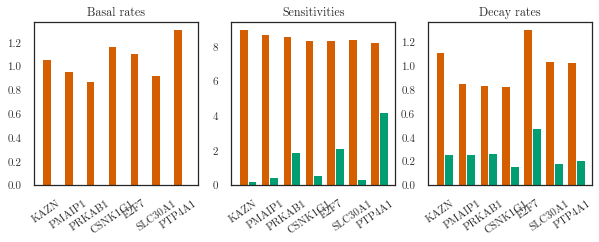

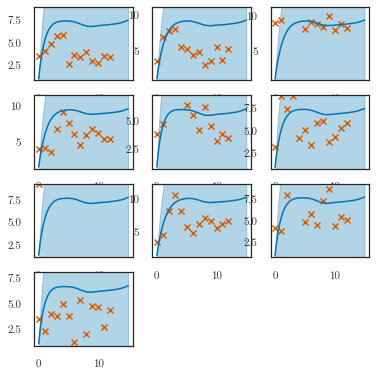

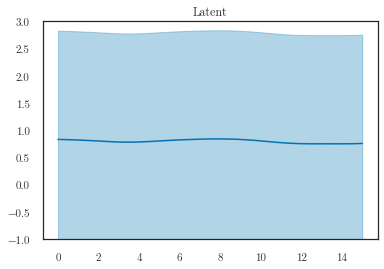

In [10]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
keys = ['raw_basal', 'raw_sensitivity', 'raw_decay']
constraints = [lfm.positivity, lfm.positivity, lfm.positivity]
kinetics = list()
for i, key in enumerate(keys):
    kinetics.append(
        constraints[i].transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
kinetics = np.array(kinetics)
print(kinetics[0].shape)
plotter.plot_double_bar(kinetics, titles=labels, figsize=(10, 3),
                        ground_truths=hafner_ground_truth(), max_plots=7)
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')

In [11]:
lfm.train()
# trainer = Trainer(optimizer)
output = trainer.train(500, step_size=5e-1, report_interval=10)

Epoch 001/500 - Loss: 817.72 (817.72 0.00) kernel: [[[1.9569149]]]
Epoch 011/500 - Loss: 343.52 (343.17 0.35) kernel: [[[1.8632126]]]
Epoch 021/500 - Loss: 167.77 (166.88 0.88) kernel: [[[1.7193565]]]
Epoch 031/500 - Loss: 100.42 (99.24 1.17) kernel: [[[1.5334733]]]
Epoch 041/500 - Loss: 94.59 (93.37 1.22) kernel: [[[1.4501202]]]
Epoch 051/500 - Loss: 84.14 (82.83 1.31) kernel: [[[1.4735246]]]
Epoch 061/500 - Loss: 79.24 (77.82 1.42) kernel: [[[1.4467689]]]
Epoch 071/500 - Loss: 75.77 (74.27 1.50) kernel: [[[1.4301206]]]
Epoch 081/500 - Loss: 72.67 (71.14 1.53) kernel: [[[1.3951668]]]
Epoch 091/500 - Loss: 70.18 (68.62 1.56) kernel: [[[1.3635198]]]
Epoch 101/500 - Loss: 68.16 (66.56 1.60) kernel: [[[1.3413497]]]
Epoch 111/500 - Loss: 66.35 (64.72 1.62) kernel: [[[1.3271182]]]
Epoch 121/500 - Loss: 64.67 (63.03 1.64) kernel: [[[1.3158929]]]
Epoch 131/500 - Loss: 63.18 (61.51 1.67) kernel: [[[1.2960577]]]
Epoch 141/500 - Loss: 61.76 (60.08 1.68) kernel: [[[1.2838801]]]
Epoch 151/500 - Lo

### Outputs after training

torch.Size([500, 1, 80])
torch.Size([1, 80]) torch.Size([80, 1]) torch.Size([80, 80])
MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


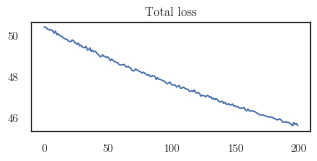

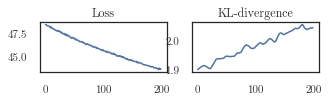

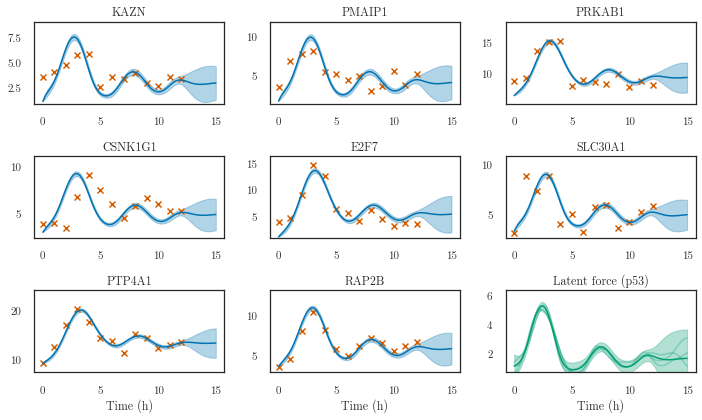

In [12]:
tight_kwargs = dict(bbox_inches='tight', pad_inches=0)
t_predict = torch.linspace(0, 15, 80, dtype=torch.float32)

lfm.eval()
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_losses(trainer, last_x=200)
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))

row = col = 0
for i in range(8):
    if i == (row+1) * 3:
        row += 1
        col = 0
    ax = axes[row, col]
    plotter.plot_gp(q_m, t_predict, replicate=0, ax=ax,# ylim=(-2, 25.2),
                    color=Colours.line_color, shade_color=Colours.shade_color,
                    t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                    only_plot_index=i, num_samples=0)
    col += 1
    ax.set_title(dataset.gene_names[i])
plotter.plot_gp(q_f, t_predict, ax=axes[nrows-1, ncols-1],
                # ylim=(-1, 5),
                transform=softplus,
                num_samples=3,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color)
axes[nrows-1, ncols-1].set_title('Latent force (p53)')
for col in range(ncols):
    axes[nrows-1, col].set_xlabel('Time (h)')

plt.tight_layout()

torch.Size([500, 1, 80])
torch.Size([1, 80]) torch.Size([80, 1]) torch.Size([80, 80])
MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


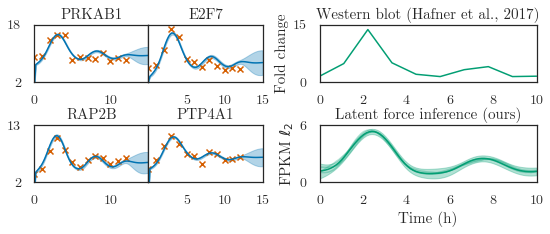

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 2.9),
                         gridspec_kw=dict(width_ratios=[1, 1, 0.5, 1.9], wspace=0, hspace=0.75))
row = col = 0
plots = [2, 4, 7, 6]
lbs = [2, 0, 2, 5]
for i in range(4):
    if i == (row+1) * 2:
        row += 1
        col = 0
    ax = axes[row, col]
    plotter.plot_gp(q_m, t_predict, replicate=0, ax=ax,# ylim=(-2, 25.2),
                    color=Colours.line_color, shade_color=Colours.shade_color,
                    t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                    only_plot_index=plots[i], num_samples=0)
    ax.set_title(dataset.gene_names[plots[i]])
    mean = q_m.mean.detach().transpose(0, 1)[plots[i]]
    lb = torch.floor(mean.min()-1)
    ub = torch.ceil(mean.max() + 1)
    brange = ub - lb
    ub = int(lb + brange*1.1)
    lb = lbs[i]
    ax.set_ylim(lb, ub)
    ax.set_xlim(0, 15)
    ax.set_yticks([lb, ub])
    ax.figure.subplotpars.wspace = 0
    if col > 0:
        ax.set_yticks([])
        ax.set_xticks([5, 10, 15])

    col += 1
y = [1.5, 4.8, 13.7, 5, 2, 1.4, 3.2, 4, 1.4, 1.5]
# y = y/np.mean(y)*np.mean(p) * 1.75-0.16
# y = scaler.fit_transform(np.expand_dims(y, 0))
axes[0, 3].plot(np.linspace(0, 10, len(y)), y, color=Colours.line2_color)
axes[0, 3].set_ylim(0, 15)
axes[0, 3].set_ylabel('Fold change')
axes[0, 3].set_yticks([0.0, 15.0])
axes[0, 3].set_title('Western blot (Hafner et al., 2017)')
t_temp = torch.linspace(0, 10, 80, dtype=torch.float32)
q_f = lfm.predict_f(t_temp)
plotter.plot_gp(q_f, t_temp, ax=axes[1, 3],
                transform=softplus,
                num_samples=3,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color)
axes[1, 3].set_yticks([0, 4])
for i in range(2):
    axes[i, 3].set_xlim(0, 10)
    axes[i, 2].set_visible(False)

axes[1, 3].set_title('Latent force inference (ours)')
axes[1, 3].set_xlabel('Time (h)')
axes[1, 3].set_ylabel('FPKM $\ell_2$')
axes[1, 3].set_yticks([0.0, 6.0])
axes[1, 3].set_ylim(0.0, 6)
fig.tight_layout()

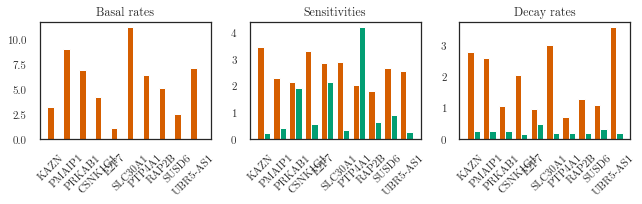

In [9]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
keys = ['raw_basal', 'raw_sensitivity', 'raw_decay']
constraints = [lfm.positivity, lfm.positivity, lfm.positivity]
kinetics = list()
for i, key in enumerate(keys):
    kinetics.append(
        constraints[i].transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

plotter.plot_double_bar(kinetics, labels,
                        figsize=(9, 3),
                        ground_truths=hafner_ground_truth())
                        # yticks=[
                        #     np.linspace(0, 0.12, 5),
                        #     np.linspace(0, 1.2, 4),
                        #     np.arange(0, 1.1, 0.2),
                        # ])
plt.tight_layout()
# plt.savefig('./hafner-kinetics.pdf', **tight_kwargs)

# plotter.plot_convergence(trainer)